# Бинарная классификация изображений (лисы и бабочки)

Постановка задачи: даны изображения лис и бабочек (в соответствующих папках папки data). Необходимо замешать их и обучить бинарный классификатор

In [70]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from tqdm import tqdm

### Загрузка файлов

In [15]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


def load_images_from_folder(folder: str, target: int):
    tensors = []
    targets = []
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if os.path.isfile(file_path) and file_name.endswith(".jpg"):
            # Загрузка изображения и преобразование в тензор
            image = Image.open(file_path).convert("RGB")
            tensor = transform(image)
            tensors.append(tensor)
            targets.append(target)
    return tensors, targets

In [14]:
foxes_dir = "data/foxes_images/" 
butterflies_dir = "data/butterflies_images/" 

In [16]:
fox_tensors, fox_targets = load_images_from_folder(foxes_dir, 0) # пусть лисы будут классом 0
butterfly_tensors, butterfly_targets = load_images_from_folder(butterflies_dir, 1) # а бабочки классом 1

all_tensors = fox_tensors + butterfly_tensors
all_targets = fox_targets + butterfly_targets

all_tensors = torch.stack(all_tensors)
all_targets = torch.tensor(all_targets)

# перемешиваю картинки
indices = torch.randperm(len(all_tensors))
all_tensors = all_tensors[indices]
all_targets = all_targets[indices]


In [48]:
fox_tensors[0].shape

torch.Size([3, 128, 128])

In [17]:
print(f"Количество картинок с лисами: {len(fox_tensors)}")
print(f"Количество картинок с бабочками: {len(butterfly_tensors)}")

Количество картинок с лисами: 1080
Количество картинок с бабочками: 1130


In [21]:
class CustomDataset(Dataset):
    def __init__(self, tensors, targets):
        self.tensors = tensors
        self.targets = targets

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        return self.tensors[idx], self.targets[idx]

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [25]:
# загрузка датасетов
train_tensors, test_tensors, train_targets, test_targets = train_test_split(
    all_tensors, all_targets, test_size=0.2, random_state=42
)

train_dataset = CustomDataset(train_tensors, train_targets)
test_dataset = CustomDataset(test_tensors, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Размер тренировочной выборки: {len(train_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")

Размер тренировочной выборки: 1768
Размер тестовой выборки: 442


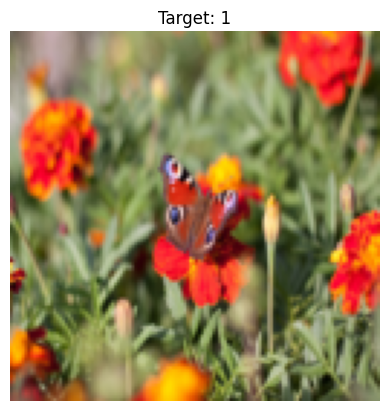

In [33]:
# пример изображения
def show_example(dataset, sample=0):
    tensor, target = dataset[sample]
    image = tensor.permute(1, 2, 0).numpy() * 0.5 + 0.5  # обратное преобразование
    plt.imshow(image)
    plt.title(f"Target: {target}")
    plt.axis("off")
    plt.show()

show_example(train_dataset)

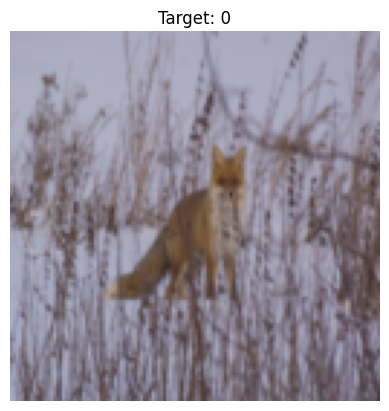

In [37]:
show_example(train_dataset, 255)

## Эксперименты (с помощью dvc)

### Создание модели

In [63]:
class AnimalsClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = self.train_block(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2)  
        self.block2 = self.train_block(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2) 
        
        self.block3 = self.train_final_block(32*32*16, 128, drop_out=0.2)


    def train_block(self, in_channels, out_channels, kernel_size, padding, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size-1, stride=stride), 
        )
    
    def train_final_block(self, in_channels, out_channels, drop_out):
        return nn.Sequential(nn.Flatten(),
            nn.Linear(in_channels, out_channels), 
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(out_channels, 2)
            )  # Выходной слой для 2 классов


    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x
    

In [64]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

In [65]:
def train_model(model, train_loader, device, num_epochs=10, learning_rate=0.001):
    model.to(device)
    model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    acc_history = []

    with tqdm(total=len(train_loader) * num_epochs, position=0) as pbar:
        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0

            for batch_num, (inputs, labels) in enumerate(train_loader):
                # inputs = inputs.permute(0, 3, 1, 2).to(device)  
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct / batch_total

                pbar.set_description(f"Epoch: {epoch}, Batch: {batch_num}, Loss: {running_loss:.2f}, Acc: {batch_acc:.2f}")
                pbar.update()

                total += batch_total
                correct += batch_correct

            epoch_acc = correct / total
            acc_history.append(epoch_acc)

        pbar.close()

    return acc_history


### Обучение

In [66]:
model = AnimalsClassifier()
acc_history = train_model(model, train_loader, device, num_epochs=10, learning_rate=0.001)

  0%|          | 0/560 [00:00<?, ?it/s]

Epoch: 9, Batch: 55, Loss: 6.90, Acc: 1.00: 100%|██████████| 560/560 [00:58<00:00,  9.52it/s] 


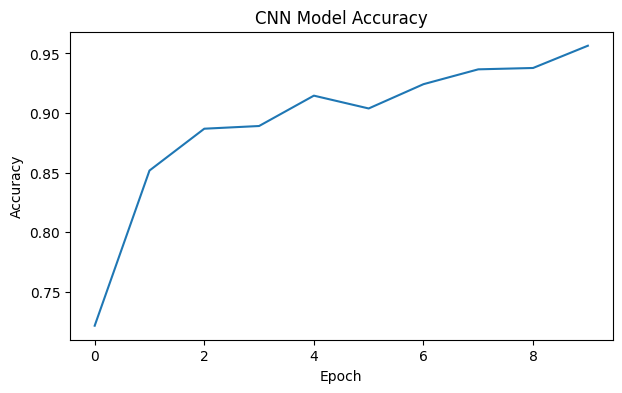

In [67]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

print_history(acc_history, "CNN Model Accuracy")

In [73]:
def test(net, test_dataloader, device):
    net.to(device)
    net.eval()
    
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print('Точность на тестовых данных: {:.2f} %'.format(accuracy))
    print(classification_report(all_labels, all_predictions, target_names=["0", "1"]))


test_dataloader = DataLoader(test_dataset, batch_size=32) 
test(model, test_dataloader, device)


Точность на тестовых данных: 86.20 %
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       217
           1       0.93      0.79      0.85       225

    accuracy                           0.86       442
   macro avg       0.87      0.86      0.86       442
weighted avg       0.87      0.86      0.86       442

